In [1]:
import sys
import tensorflow as tf
import random
import numpy as np
tf.reset_default_graph()

def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False
    
if in_ipynb(): 
    print("In IPython")
    exec("import Tools.TrainConfig as Conf")
    TrainConfig="Tools/TrainConfig"
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")
    

W0419 22:46:28.323630 139904413443904 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'IPKernelApp': {'connection_file': '/scratch/akapoor/.local/share/jupyter/runtime/kernel-f6e3e7c9-87a9-4f65-a698-3d097c89ea36.json'}, 'InteractiveShellApp': {'extensions': <traitlets.config.loader.LazyConfigValue object at 0x7f3df60c5748>}}
In IPython


In [2]:
if not hasattr(Conf, 'MVAlogplot'): Conf.MVAlogplot=False 
if not hasattr(Conf, 'Multicore'): Conf.Multicore=False 
if not hasattr(Conf, 'RandomState'): Conf.RandomState=42

In [3]:
tf.compat.v1.random.set_random_seed(Conf.RandomState)
random.seed(Conf.RandomState)
np.random.seed(Conf.RandomState)

import os
os.system("")
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

Welcome to JupyROOT 6.18/00


In [4]:
from Tools.PlotTools import *
import Tools.ptetaRwt as ptetaRwt

In [5]:
if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

 Running in debug mode : Only every 10th event will be used


In [6]:
if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd)
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")

 Making output directory


0

In [7]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [8]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(Conf.SigFiles,Conf.SigXsecWts,Conf.SigCuts):
    if Conf.Debug==True:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Conf.Tree).pandas.df().query(SigCut+' & '+Conf.CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(Conf.BkgFiles,Conf.BkgXsecWts,Conf.BkgCuts):
    if Conf.Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Conf.Tree).pandas.df().query(BkgCut+' & '+Conf.CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)

 Making data frames


Reweighting Now...
BSum 356
SSum 5185
Entering1
BSum 1374.0
SSum 23058
Entering1
BSum 154.0
SSum 2336
Entering1
BSum 168.0
SSum 2672
Entering1
BSum 0.0
SSum 0
Entering2
BSum 60.0
SSum 4628
Entering1
BSum 246.0
SSum 20347
Entering1
BSum 32.0
SSum 2040
Entering1
BSum 30.0
SSum 2313
Entering1
BSum 0.0
SSum 0
Entering2
BSum 24.0
SSum 3076
Entering1
BSum 156.0
SSum 17398
Entering1
BSum 20.0
SSum 1477
Entering1
BSum 24.0
SSum 1671
Entering1
BSum 0.0
SSum 0
Entering2
BSum 72.0
SSum 1187
Entering1
BSum 316.0
SSum 7042
Entering1
BSum 22.0
SSum 540
Entering1
BSum 28.0
SSum 635
Entering1
BSum 0.0
SSum 0
Entering2
BSum 156.0
SSum 112
Entering1
BSum 562.0
SSum 596
Entering1
BSum 82.0
SSum 43
Entering1
BSum 70.0
SSum 54
Entering1
BSum 0.0
SSum 0
Entering2
BSum 0.0
SSum 0
Entering2
BSum 0.0
SSum 0
Entering2
BSum 0.0
SSum 0
Entering2
BSum 0.0
SSum 0
Entering2
BSum 0.0
SSum 0
Entering2


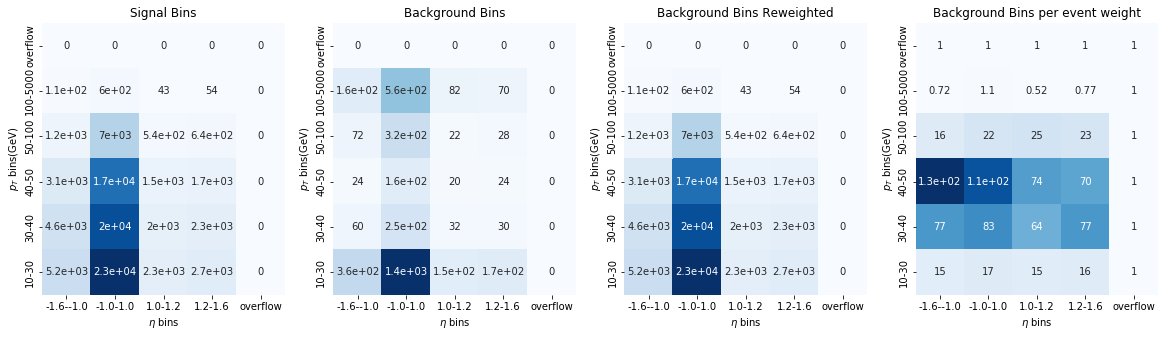

In [9]:
Sigdf[cat]=1
Bkgdf[cat]=0

Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

if Conf.Reweighing=='Nothing':
    Sigdf[weight]=Sigdf['xsecwt']
    Bkgdf[weight]=Bkgdf['xsecwt']
if Conf.Reweighing=='ptetaSig':
    Sigdf[weight],Bkgdf[weight]=ptetaRwt.ptetaRwtTested(Sigdf.copy(),Bkgdf.copy(),Conf.ptbins,Conf.etabins,'xsecwt',weight,ele_pt='ele_pt',scl_eta='scl_eta',od=Conf.OutputDirName)
if Conf.Reweighing=='ptetaBkg':
    Bkgdf[weight],Sigdf[weight]=ptetaRwt.ptetaRwtTested(Bkgdf.copy(),Sigdf.copy(),Conf.ptbins,Conf.etabins,'xsecwt',weight,ele_pt='ele_pt',scl_eta='scl_eta',od=Conf.OutputDirName)

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

#df_final["NewWt"]=1

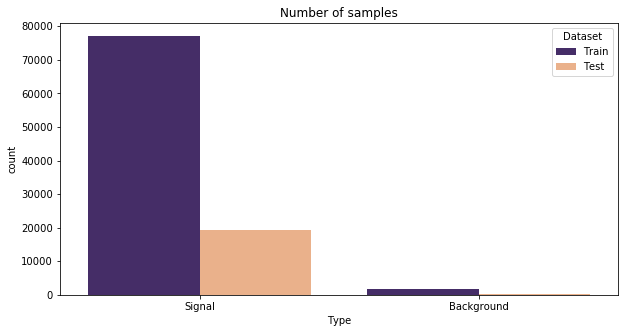

In [10]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")
    

In [11]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]
    
    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
 XGB_1 Applying MinMaxScaler
 XGB_1 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.6s finished


 Expected neg log loss of XGB model = -5.0%
 XGB Best Parameters
 {'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB
 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots
 XGB_2 Applying StandardScaler
 XGB_2 Training starting
 Performing XGB grid search
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   24.3s finished


 Expected neg log loss of XGB model = -5.5%
 XGB Best Parameters
 {'gamma': 1, 'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB


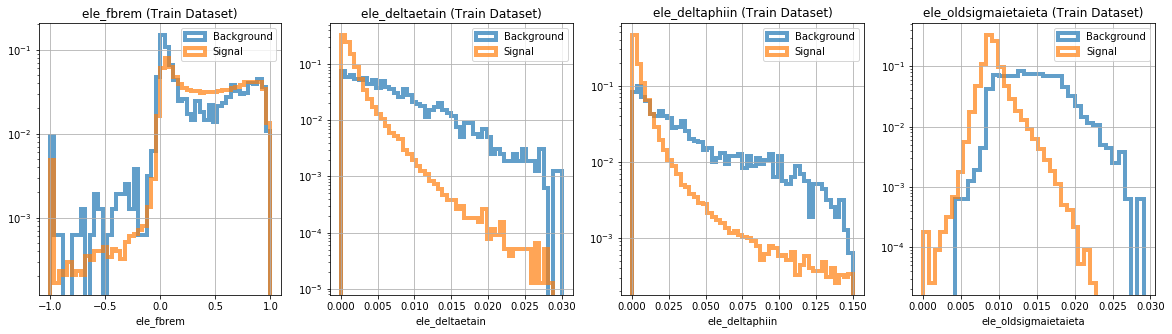

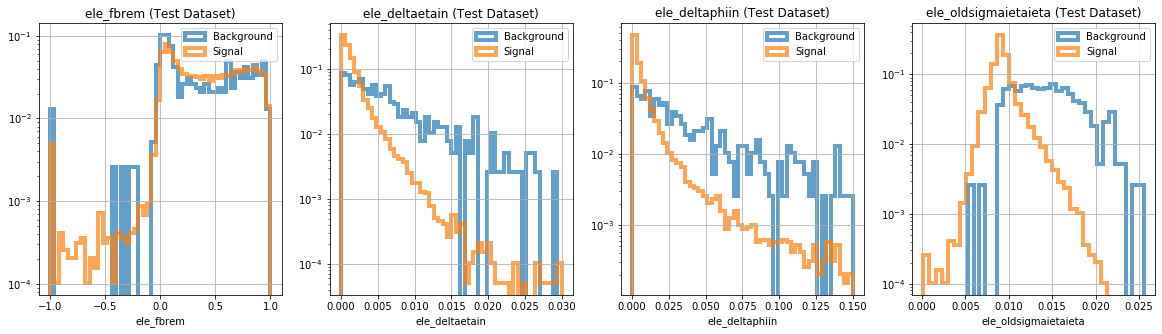

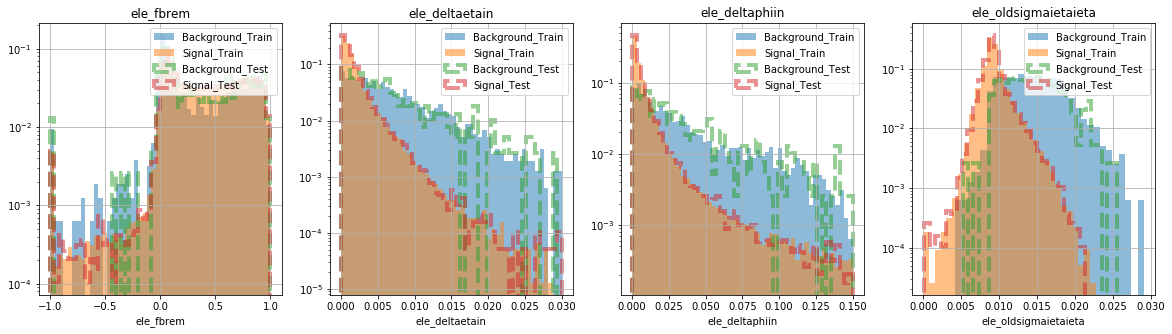

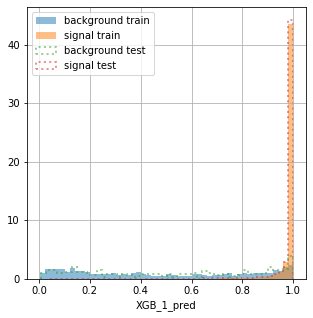

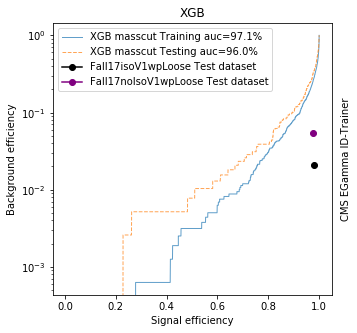

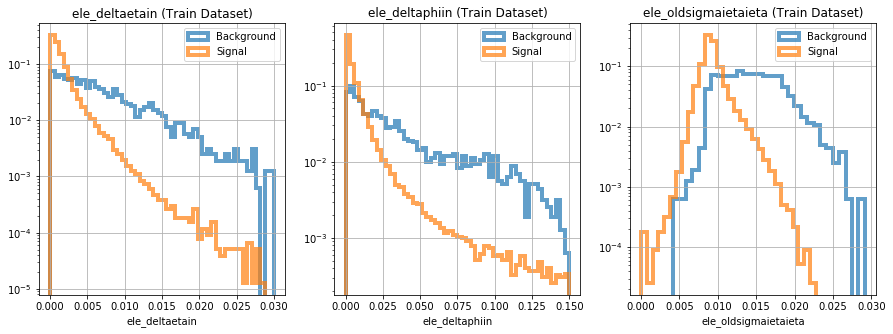

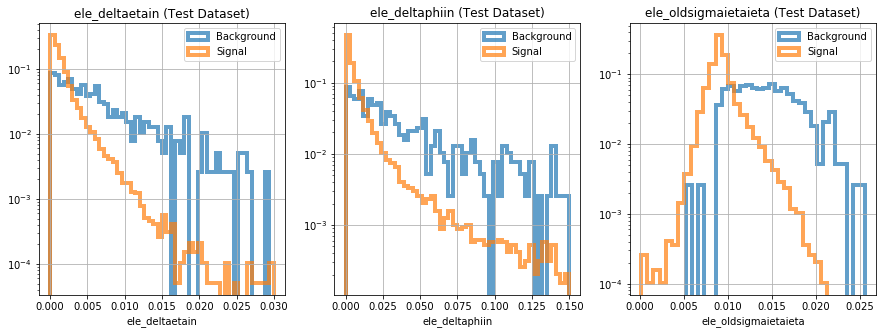

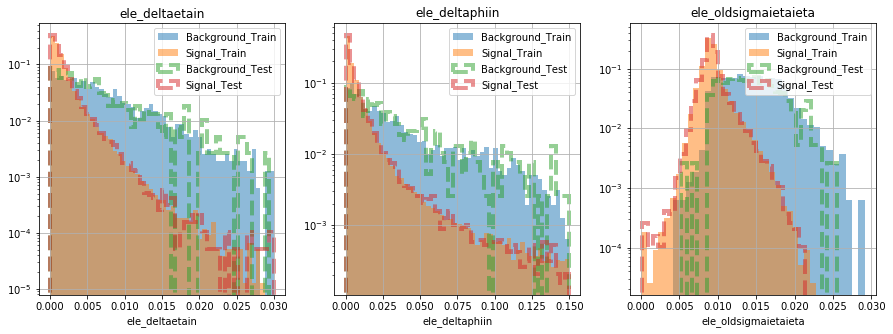

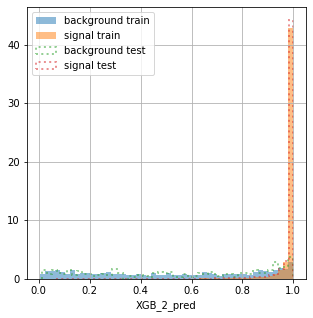

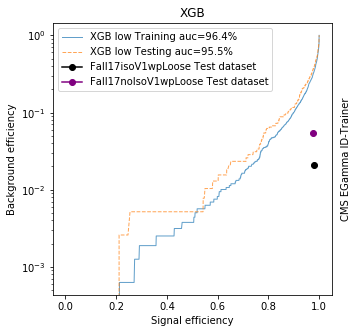

In [12]:
import pickle
import multiprocessing
for MVA in Conf.MVAs:
    
    if 'XGB' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Applying "+Conf.Scaler[MVA])
        exec("from sklearn.preprocessing import "+Conf.Scaler[MVA])
        exec("sc = "+Conf.Scaler[MVA]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen(MVA+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=Conf.RandomState)
        #xgb_model.set_config(verbosity=2)
        prGreen("Performing XGB grid search")
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=2)#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, Conf.XGBGridSearch[MVA],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelXGB.pkl", "wb"))
        #modelDNN.save(Conf.OutputDirName+"/"+MVA+"_"+"modelDNN.h5")
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
    
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
    
        df_final.loc[TrainIndices,MVA+"_pred"]=cv.predict_proba(X_train)[:,1]
        df_final.loc[TestIndices,MVA+"_pred"]=cv.predict_proba(X_test)[:,1]
    
        prGreen("Plotting output response for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBMVA.png")
    
        prGreen("Plotting ROC for XGB")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("XGB")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"XGBROC.png")

 MakingTrain dataset feature plots
 MakingTest dataset feature plots
 Making Combined dataset feature plots


W0419 22:48:29.214363 139904413443904 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 DNN_1 Applying MinMaxScaler
 DNN fitting running
Train on 78708 samples, validate on 19678 samples
Epoch 1/10
78708/78708 [==============================] - 2s 26us/sample - loss: 0.3217 - acc: 0.9306 - val_loss: 0.1689 - val_acc: 0.9804
Epoch 2/10
78708/78708 [==============================] - 1s 16us/sample - loss: 0.1903 - acc: 0.9793 - val_loss: 0.1342 - val_acc: 0.9792
Epoch 3/10
78708/78708 [==============================] - 1s 15us/sample - loss: 0.1501 - acc: 0.9772 - val_loss: 0.1083 - val_acc: 0.9793
Epoch 4/10
78708/78708 [==============================] - 1s 15us/sample - loss: 0.1247 - acc: 0.9792 - val_loss: 0.0980 - val_acc: 0.9808
Epoch 5/10
78708/78708 [==============================] - 1s 15us/sample - loss: 0.1118 - acc: 0.9803 - val_loss: 0.0922 - val_acc: 0.9811
Epoch 6/10
78708/78708 [==============================] - 1s 15us/sample - loss: 0.1046 - acc: 0.9811 - val_loss: 0.0897 - val_acc: 0.9818
Epoch 7/10
78708/78708 [==============================] - 1s 15us/

2021-04-19 22:48:30.157174: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-04-19 22:48:30.178699: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2399750000 Hz
2021-04-19 22:48:30.180136: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xd97e100 executing computations on platform Host. Devices:
2021-04-19 22:48:30.180183: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-04-19 22:48:30.282662: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

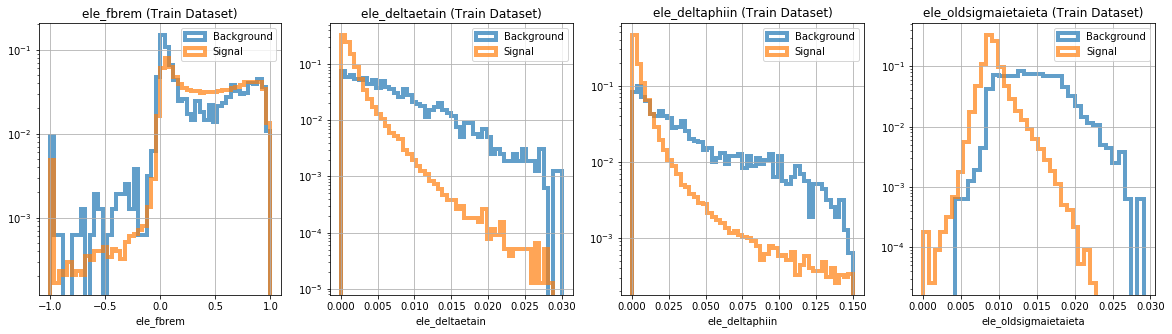

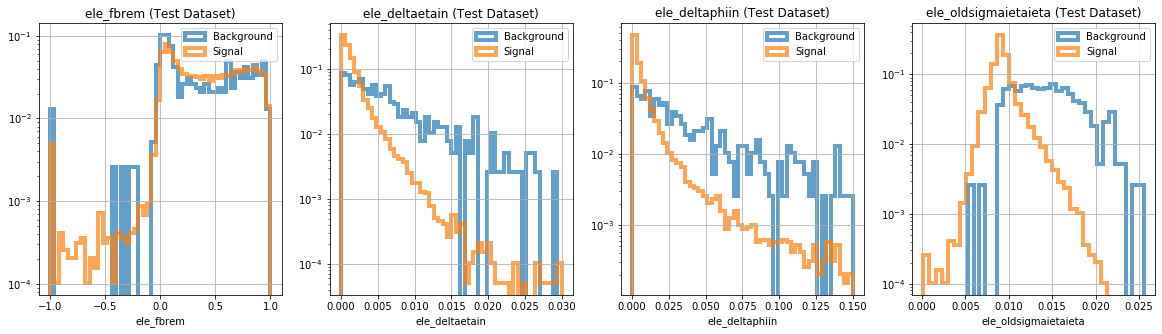

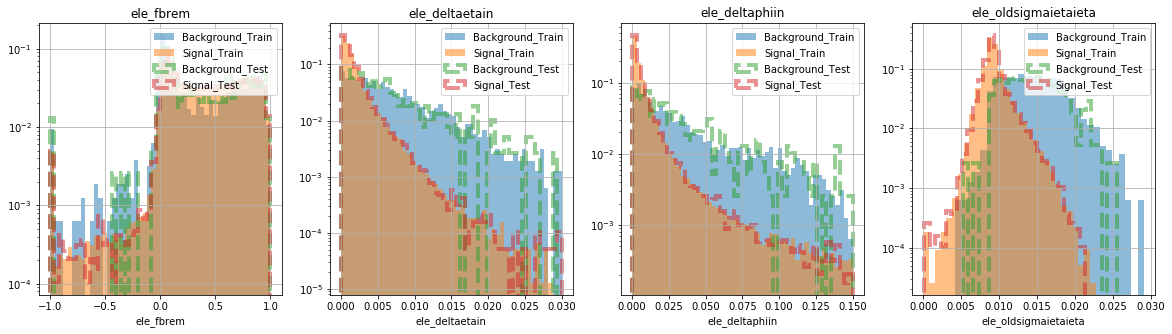

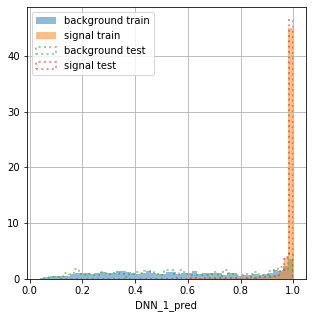

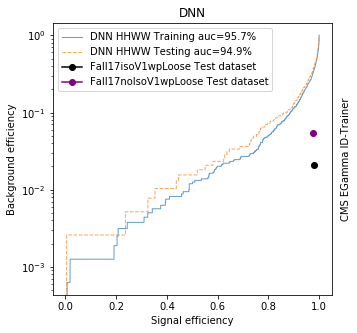

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
for MVA in Conf.MVAs:
    if 'DNN' in MVA:
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Train",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlots(df_final,Conf.features[MVA],Conf.feature_bins[MVA],Set="Test",MVA=MVA,OutputDirName=Conf.OutputDirName)
        MakeFeaturePlotsComb(df_final,Conf.features[MVA],Conf.feature_bins[MVA],MVA=MVA,OutputDirName=Conf.OutputDirName)
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,Conf.features[MVA],cat,weight)
        prGreen(MVA+" Applying "+Conf.Scaler[MVA])
        exec("from sklearn.preprocessing import "+Conf.Scaler[MVA])
        exec("sc = "+Conf.Scaler[MVA]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen("DNN fitting running")
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        modelDNN=Conf.DNNDict[MVA]['model']
        modelDNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=Conf.DNNDict[MVA]['lr']), metrics=['accuracy',])
        train_history = modelDNN.fit(X_train,Y_train,epochs=Conf.DNNDict[MVA]['epochs'],batch_size=Conf.DNNDict[MVA]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"modelDNN.h5")
        df_final.loc[TrainIndices,MVA+"_pred"]=modelDNN.predict(X_train)
        df_final.loc[TestIndices,MVA+"_pred"]=modelDNN.predict(X_test)
    
        prGreen("Plotting output response for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_mva(df_final.query('TrainDataset==1'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=Conf.MVAlogplot)
        plot_mva(df_final.query('TrainDataset==0'),MVA+"_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=Conf.MVAlogplot)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNMVA.png")
    
        prGreen("Plotting ROC for DNN")
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        plot_roc_curve(df_final.query('TrainDataset==1'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label=Conf.MVALabels[MVA]+' Training',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==0'),MVA+"_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label=Conf.MVALabels[MVA]+' Testing',cat=cat,Wt=weight)
        if len(Conf.OverlayWP)>0:
            for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
                plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
        axes.set_ylabel("Background efficiency")
        axes.set_xlabel("Signal efficiency")
        axes.set_title("DNN")
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
            horizontalalignment='center',
            verticalalignment='center',
            rotation='vertical',
            transform=axes.transAxes)
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA+"/"+MVA+"_"+"DNNROC.png")

In [14]:
if 'Genetic' in Conf.MVAs:
    prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

 Plotting Final ROC


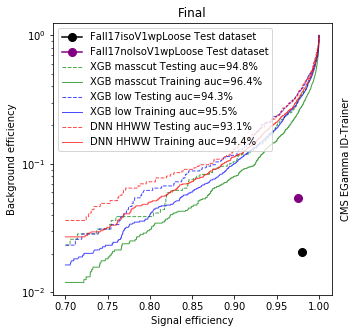

In [15]:
##PlotFinalROC
prGreen("Plotting Final ROC")
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if len(Conf.OverlayWP)>0:
    for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
        plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
if len(Conf.MVAs)>0:
    for color,MVAi in zip(Conf.MVAColors,Conf.MVAs):
        plot_roc_curve(df_final.query('TrainDataset==0'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='--', label=Conf.MVALabels[MVAi]+' Testing',cat=cat,Wt=weight)
        plot_roc_curve(df_final.query('TrainDataset==1'),MVAi+"_pred", tpr_threshold=0.7, ax=axes, color=color, linestyle='-', label=Conf.MVALabels[MVAi]+' Training',cat=cat,Wt=weight)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("Final")
    axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
        horizontalalignment='center',
        verticalalignment='center',
        rotation='vertical',
        transform=axes.transAxes)
plt.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
plt.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [16]:
PredMVAs=[]
for MVA in Conf.MVAs:
    PredMVAs.append(MVA+'_pred')
SigEffWPs=Conf.SigEffWPs[:]
for i,SigEffWPi in enumerate(SigEffWPs):
    SigEffWPs[i]=int(SigEffWPi.replace('%', ''))/100

if len(Conf.MVAs)>0:
    prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
    mydf=df_final.query("TrainDataset==1 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
    mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    mydf2=df_final.query("TrainDataset==0 & EleType==1")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)
    mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
    mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

 Threshold values for requested Signal Efficiencies (Train Dataset)
      XGB_1_pred  XGB_2_pred  DNN_1_pred
WPs                                    
80%    0.999026    0.998992     0.99609
90%    0.999376    0.999378     0.99708
 Threshold values for requested Signal Efficiencies (Test Dataset)
      XGB_1_pred  XGB_2_pred  DNN_1_pred
WPs                                    
80%    0.999026    0.998992    0.996048
90%    0.999354    0.999355    0.997066


In [17]:
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')

 Done!! Please find the quick look ROC pdf here Output/mydocROC.pdf
 Done!! Please find the quick look MVA pdf here Output/mydocMVA.pdf
 Individual plots and saved model files can be found in directory: Output/


In [18]:
if hasattr(Conf, 'SaveDataFrameCSV'): 
    if Conf.SaveDataFrameCSV:
        prGreen("Saving DataFrame : Can take a lot of time")
        os.system("mkdir -p " + Conf.OutputDirName+"/DataFrame")    
        df_final.to_csv(Conf.OutputDirName+'/DataFrame/df_final.csv')